# Определение перспективного тарифа для телеком-компании

## Описание проекта

Компания «Мегалайн» — федеральный оператор сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Нам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Описание тарифов

**Тариф «Смарт»**
1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
    * минута разговора: 3 рубля
    * сообщение: 3 рубля
    * 1 Гб интернет-трафика: 200 рублей
**Тариф «Ультра»**
1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
    * минута разговора: 1 рубль
    * сообщение: 1 рубль
    * 1 Гб интернет-трафика: 150 рублей

## Описание данных

**Таблица users (информация о пользователях):**
* user_id — уникальный идентификатор пользователя
* first_name — имя пользователя
* last_name — фамилия пользователя
* age — возраст пользователя (годы)
* reg_date — дата подключения тарифа (день, месяц, год)
* churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* city — город проживания пользователя
* tariff — название тарифного плана

**Таблица calls (информация о звонках):**
* id — уникальный номер звонка
* call_date — дата звонка
* duration — длительность звонка в минутах
* user_id — идентификатор пользователя, сделавшего звонок

**Таблица messages (информация о сообщениях):**
* id — уникальный номер сообщения
* message_date — дата сообщения
* user_id — идентификатор пользователя, отправившего сообщение

**Таблица internet (информация об интернет-сессиях):**
* id — уникальный номер сессии
* mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
* session_date — дата интернет-сессии
* user_id — идентификатор пользователя

**Таблица tariffs (информация о тарифах):**
* tariff_name — название тарифа
* rub_monthly_fee — ежемесячная абонентская плата в рублях
* minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
* messages_included — количество сообщений в месяц, включённых в абонентскую плату
* mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* rub_per_message — стоимость отправки сообщения сверх тарифного пакета
* rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## Шаг 1. Откроем файл с данными и изучите общую информацию

In [722]:
# Импортируем библиотеки

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy
# from math import ceil as math
import math
from functools import reduce

In [568]:
# Читаем файлы csv

users = pd.read_csv('/Users/danil/Desktop/Data Science/Яндекс Практикум Data Science/4/[SLIV.SITE]Яндекс-практикус часть 4-16/05 Проектная работа/datasets/users.csv')
calls = pd.read_csv('/Users/danil/Desktop/Data Science/Яндекс Практикум Data Science/4/[SLIV.SITE]Яндекс-практикус часть 4-16/05 Проектная работа/datasets/calls.csv')
messages = pd.read_csv('/Users/danil/Desktop/Data Science/Яндекс Практикум Data Science/4/[SLIV.SITE]Яндекс-практикус часть 4-16/05 Проектная работа/datasets/messages.csv')
internet = pd.read_csv('/Users/danil/Desktop/Data Science/Яндекс Практикум Data Science/4/[SLIV.SITE]Яндекс-практикус часть 4-16/05 Проектная работа/datasets/internet.csv')
tariffs = pd.read_csv('/Users/danil/Desktop/Data Science/Яндекс Практикум Data Science/4/[SLIV.SITE]Яндекс-практикус часть 4-16/05 Проектная работа/datasets/tariffs.csv')

In [569]:
# Создаем список csv файлов

list_of_csv = [users, calls, messages, internet, tariffs]

In [570]:
# Выводим информацию о таблицах

for i in list_of_csv:
    display(i.head())
    display(i.info())
    display(i.isna().sum())

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


None

user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


None

id           0
call_date    0
duration     0
user_id      0
dtype: int64

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


None

id              0
message_date    0
user_id         0
dtype: int64

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


None

Unnamed: 0      0
id              0
mb_used         0
session_date    0
user_id         0
dtype: int64

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


None

messages_included        0
mb_per_month_included    0
minutes_included         0
rub_monthly_fee          0
rub_per_gb               0
rub_per_message          0
rub_per_minute           0
tariff_name              0
dtype: int64

<div class="alert alert-block alert-info">
    <ul type='circle'>

## Вывод по изучению общей информации
        
1. Пропуски есть лишь в столбце даты прекращения пользования тарифом, которые означают, что тариф остается активным. Их заполнять не будем.
        
2. Поменяем типы данных в колонке:      
**users**
* churn_date: object → date
* reg_date: object → date

**calls**
* id: object → int64
* call_date: object → date
* duration (перед этим округлив в большую сторону): float64 → int64

**messages**
* id: object → int64
* message_date: object → date

**internet**
* id: object → int64
* session_date: object → date
        
3. Соединим таблицы users, calls, messages и internet в одну по колонке user_id. Таблицу tariffs оставим отдельной, так как в ней находятся условия тарифов без привязки к пользователям.
        
4. 'Unnamed: 0' в internet удалить, так как она дублирует колонку индексов

## Шаг 2. Подготовим данные

### 2.1 Приведим данные к нужным типам

In [571]:
# Поскольку даже одна секунда звонка окургляется до минуты
# Округлим все значения колонки duration в большую сторону

calls['duration'].apply(lambda x: math.ceil(x))

0          0
1          0
2          3
3         14
4          6
          ..
202602     1
202603    19
202604    11
202605     5
202606    20
Name: duration, Length: 202607, dtype: int64

In [572]:
# С помощью циклов поменяем типы данных в колонках

csv_columns = [
    'churn_date', 'reg_date', 'id', 'call_date', 
    'duration', 'message_date', 'session_date'
]

for i in list_of_csv:
    for j in i.columns:
        if j in csv_columns:
            if 'date' in j:
                i[j] = pd.to_datetime(i[j], format='%Y-%m-%d')
            else:
                i[j] = i[j].astype('int')

In [573]:
# Удалим колонку Unnamed в таблице internet

internet = internet.drop('Unnamed: 0', axis=1)

### 2.2 Посчитаем для каждого пользователя количество сделанных звонков и израсходованных минут разговора по месяцам

In [574]:
# Добавляем столбец с месяцем звонка

calls['month'] = calls['call_date'].dt.month

In [575]:
# Переиминуем столбец id, 
# чтобы не путаться когда сделаем merge

calls = calls.rename(
columns={
'id': 'call_id'}
)

In [576]:
# Считаем для каждого пользователя 
# количество сделанных звонков 
# и израсходованных минут разговора по месяцам
# сохраним в отдельную таблицу

calls_per_month = calls.groupby(['user_id', 'month'], as_index=False).agg({'call_id':'count', 'duration':'sum'})

### 2.3 Посчитаем для каждого пользователя количество отправленных сообщений по месяцам

In [577]:
# Добавляем столбец с месяцем сообщения

messages['month'] = messages['message_date'].dt.month

In [578]:
# Переиминуем столбец id, 
# чтобы не путаться когда сделаем merge

messages = messages.rename(
columns={
'id': 'message_id'}
)

In [579]:
# Считаем для каждого пользователя 
# количество отправленных сообщений по месяцам
# сохраним в отдельную таблицу

messages_per_month = messages.groupby(['user_id', 'month'], as_index=False).agg({'message_id':'count'})

### 2.4 Посчитаем для каждого пользователя объем израсходованного интернет-трафика по месяцам

In [580]:
# Добавляем столбец с месяцем интернет-трафика

internet['month'] = internet['session_date'].dt.month

In [581]:
# Переиминуем столбец id, 
# чтобы не путаться когда сделаем merge

internet = internet.rename(
columns={
'id': 'session_id'}
)

In [582]:
# Считаем для каждого пользователя 
# объем израсходованного интернет-трафика по месяцам
# сохраним в отдельную таблицу

internet_per_month = internet.groupby(['user_id', 'month'], as_index=False).agg({'mb_used':'sum'})

In [583]:
# 

# internet_per_month['mb_used'] = internet_per_month['mb_used'] / 1000
# internet_per_month['mb_used'].apply(lambda x: math.ceil(x))

### 2.5 Посчитаем для каждого пользователя помесячную выручку с каждого пользователя (вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножим на значение из тарифного плана; прибавим абонентскую плату, соответствующую тарифному плану).

In [584]:
# Переиминуем столбец tariff_name в tariff, 
# чтобы сделать merge() с таблицей users

tariffs = tariffs.rename(
columns={
'tariff_name': 'tariff'}
)

In [585]:
# Добавляем в таблицу пользователей – тарифы 

users_tariffs = users.merge(tariffs, on='tariff', how='left')

In [586]:
# Соседеним новые таблицы между собой,
# а затем с таблицей пользователей-тарифов

data_frames = [calls_per_month, messages_per_month, internet_per_month]

df = reduce(lambda left,right: 
            pd.merge(left,right,on=['user_id', 'month'],
                                            how='outer'), data_frames)

df = df.merge(users_tariffs, on='user_id', how='left')

In [587]:
# Считаем кредит минут в конце месяца

df['credit_duration'] = df['minutes_included'] - df['duration']
df['credit_duration'] = (
    df['credit_duration']
    .apply(lambda x: -x if x < 0 else 0)
)

In [588]:
# Считаем кредит смс в конце месяца

df['credit_messages'] = df['messages_included'] - df['message_id']
df['credit_messages'] = (
    df['credit_messages']
    .apply(lambda x: -x if x < 0 else 0)
)

In [589]:
# Считаем кредит интернета в конце месяца

df['credit_gb'] = df['mb_per_month_included'] - df['mb_used']
df['credit_gb'] = df['credit_gb'].apply(lambda x: -x if x < 0 else 0)
df['credit_gb'] = df['credit_gb'] / 1000
df['credit_gb'] = df['credit_gb'].apply(lambda x:  math.ceil(x))

In [590]:
# Добавляем столбец с месячной выручкой

df['revenue'] = (
    df['rub_monthly_fee'] 
    + df['credit_duration'] * df['rub_per_minute'] 
    + df['credit_messages'] * df['rub_per_message'] 
    + df['credit_gb'] * df['rub_per_gb']
)

<div class="alert alert-block alert-info">
    <ul type='circle'>

## Вывод по подготовке данных
        
        
* Привели данные к нужным типам
* Посчитали для каждого пользователя количество сделанных звонков и израсходованных минут разговора по месяцам
* Посчитали для каждого пользователя количество отправленных сообщений по месяцам
* Посчитали для каждого пользователя объем израсходованного интернет-трафика по месяцам
* Посчитали для каждого пользователя помесячную выручку с каждого пользователя

## Шаг 3. Проанализируем данные

Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.

### 3.1 Опишем поведение клиентов оператора, исходя из выборки.
Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц

In [591]:
# Санчала заменим пропуски на нули, 
# чтобы посчитать их как неиспользуемые клиентами

df[['call_id', 'duration', 'message_id', 'mb_used']] = (
    df[['call_id', 'duration', 'message_id', 'mb_used']]
    .fillna(0)
)

In [668]:
# Создадим сводную таблицу
#     

np.round(
    df.pivot_table(
    index='tariff', 
    values=['duration', 'message_id', 'mb_used'], 
    aggfunc=['mean', 'var', 'std'])
)

mean                          var                              std  \
       duration  mb_used message_id duration      mb_used message_id duration   
tariff                                                                          
smart     371.0  16208.0       33.0  28861.0   34462496.0      797.0    170.0   
ultra     468.0  19469.0       49.0  79897.0  101751014.0     2285.0    283.0   

                            
        mb_used message_id  
tariff                      
smart    5870.0       28.0  
ultra   10087.0       48.0

In [713]:
def histogram_drawing(column, title):
    sns.set_style('darkgrid')
    plt.figure(figsize=(12,6))
    plt.title(title, fontsize=15)
    sns.distplot(df.query('tariff == "ultra"')[column], label='Тариф Ultra', kde=False)
    sns.distplot(df.query('tariff == "smart"')[column], label='Тариф Smart', kde=False)
    plt.axvline(np.mean(df.query('tariff == "ultra"')[column]),color='g', linestyle='-', label='Ultra среднее')
    plt.axvline(np.mean(df.query('tariff == "smart"')[column]),color='g', linestyle='--', label='Smart среднее')
    plt.legend()
    plt.figure(figsize=(12,6))
    sns.boxplot(data=df, x=column, y='tariff')
    plt.show()
    
    print(f'Тариф «Ультра»: \n', df.query('tariff == "ultra"')[column].describe())
    print()
    print(f'Тариф «Смарт»: \n', df.query('tariff == "smart"')[column].describe())

/var/folders/r8/f9pnzbcd4rq_1f11k5rtm6w40000gn/T/ipykernel_68060/4050050405.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.query('tariff == "ultra"')[column], label='Тариф Ultra', kde=False)
/var/folders/r8/f9pnzbcd4rq_1f11k5rtm6w40000gn/T/ipykernel_68060/4050050405.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad

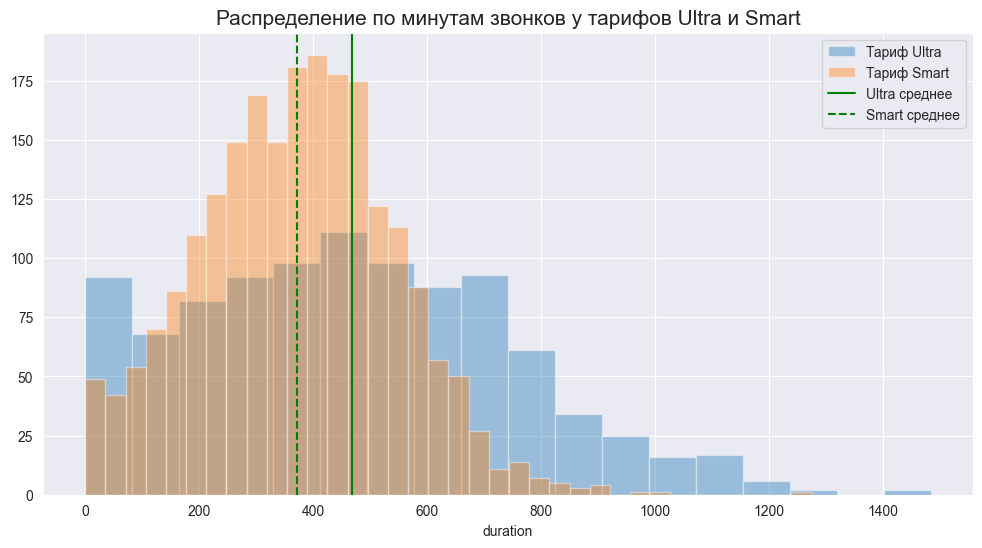

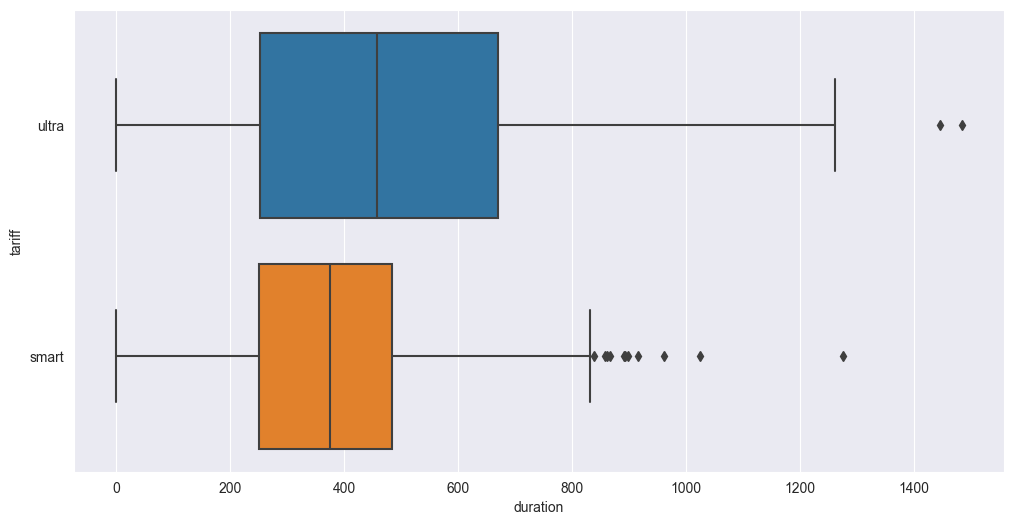

Тариф «Ультра»: 
 count     985.000000
mean      467.923858
std       282.660479
min         0.000000
25%       253.000000
50%       458.000000
75%       670.000000
max      1484.000000
Name: duration, dtype: float64

Тариф «Смарт»: 
 count    2229.000000
mean      371.444145
std       169.885089
min         0.000000
25%       251.000000
50%       375.000000
75%       485.000000
max      1275.000000
Name: duration, dtype: float64


In [714]:
histogram_drawing('duration', 'Распределение по минутам звонков у тарифов Ultra и Smart')

/var/folders/r8/f9pnzbcd4rq_1f11k5rtm6w40000gn/T/ipykernel_68060/4050050405.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.query('tariff == "ultra"')[column], label='Тариф Ultra', kde=False)
/var/folders/r8/f9pnzbcd4rq_1f11k5rtm6w40000gn/T/ipykernel_68060/4050050405.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad

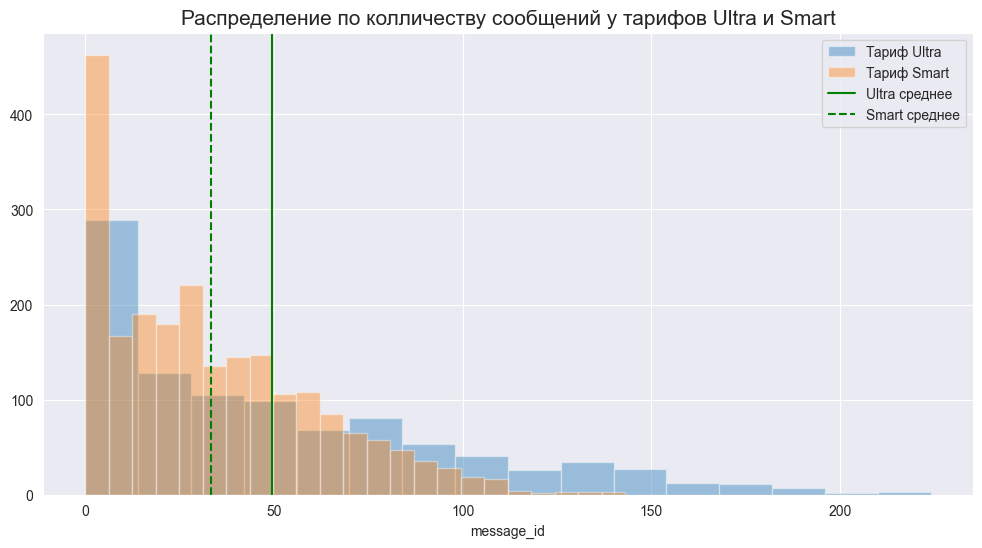

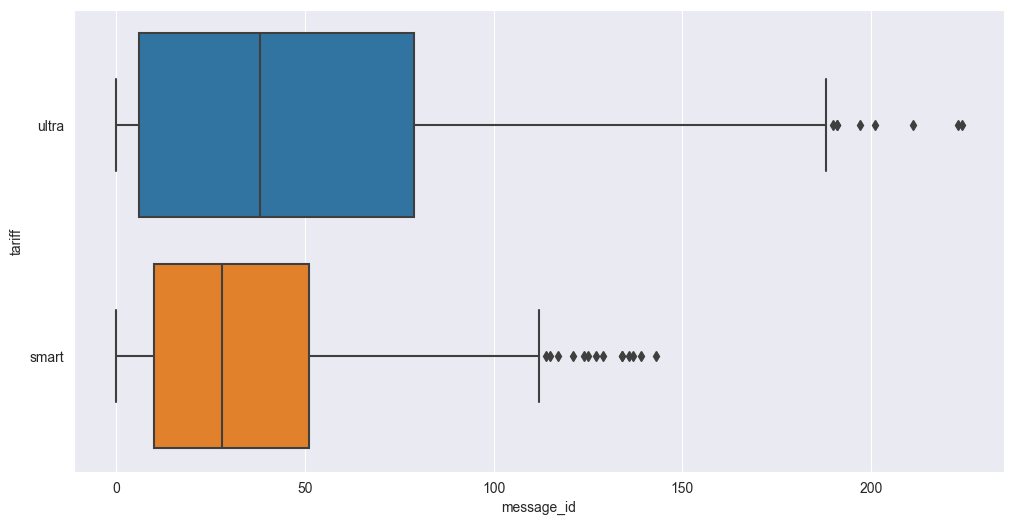

Тариф «Ультра»: 
 count    985.000000
mean      49.363452
std       47.804457
min        0.000000
25%        6.000000
50%       38.000000
75%       79.000000
max      224.000000
Name: message_id, dtype: float64

Тариф «Смарт»: 
 count    2229.000000
mean       33.384029
std        28.227876
min         0.000000
25%        10.000000
50%        28.000000
75%        51.000000
max       143.000000
Name: message_id, dtype: float64


In [715]:
histogram_drawing('message_id', 'Распределение по колличеству сообщений у тарифов Ultra и Smart')

/var/folders/r8/f9pnzbcd4rq_1f11k5rtm6w40000gn/T/ipykernel_68060/4050050405.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.query('tariff == "ultra"')[column], label='Тариф Ultra', kde=False)
/var/folders/r8/f9pnzbcd4rq_1f11k5rtm6w40000gn/T/ipykernel_68060/4050050405.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad

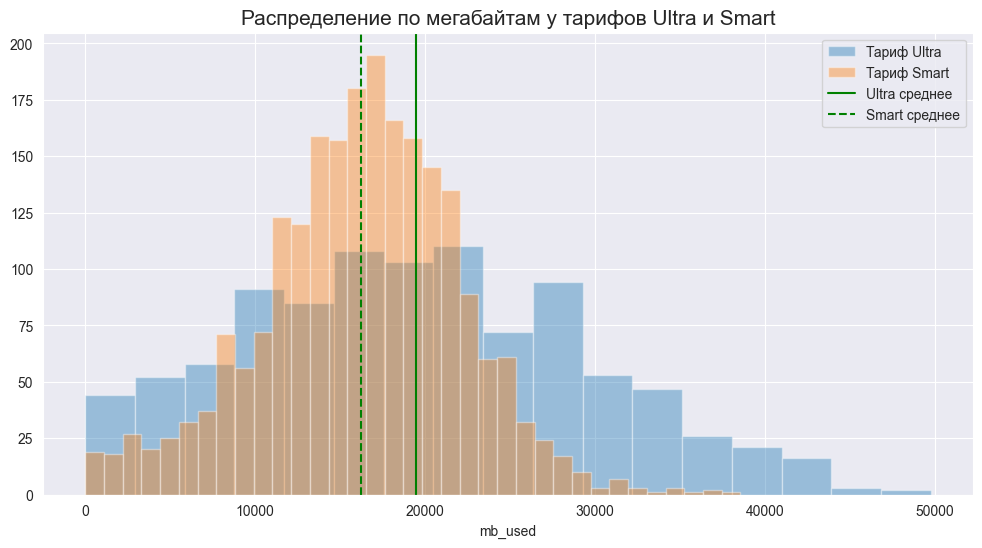

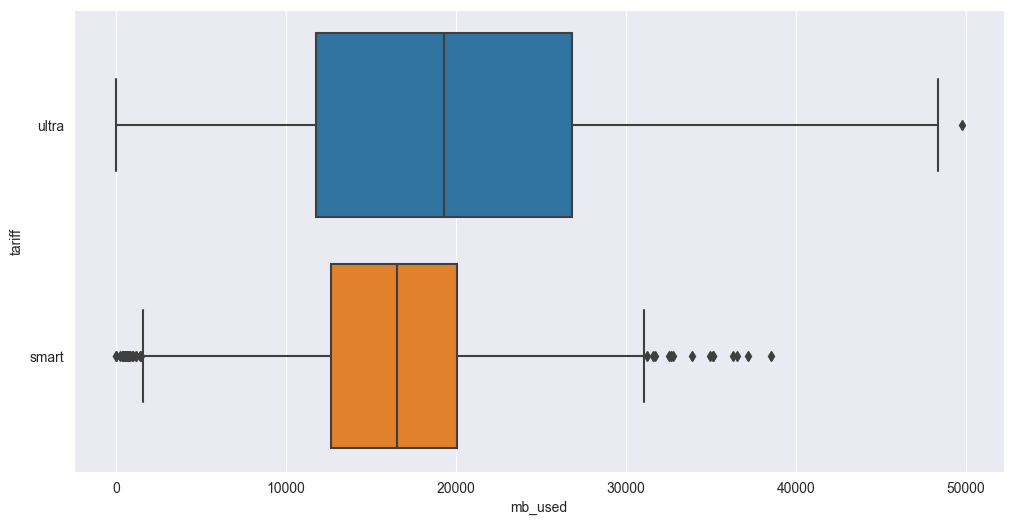

Тариф «Ультра»: 
 count      985.000000
mean     19468.805208
std      10087.170752
min          0.000000
25%      11770.260000
50%      19308.010000
75%      26837.690000
max      49745.690000
Name: mb_used, dtype: float64

Тариф «Смарт»: 
 count     2229.000000
mean     16208.386990
std       5870.476681
min          0.000000
25%      12643.010000
50%      16506.840000
75%      20042.930000
max      38552.450000
Name: mb_used, dtype: float64


In [716]:
histogram_drawing('mb_used', 'Распределение по мегабайтам у тарифов Ultra и Smart')

/var/folders/r8/f9pnzbcd4rq_1f11k5rtm6w40000gn/T/ipykernel_68060/4050050405.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.query('tariff == "ultra"')[column], label='Тариф Ultra', kde=False)
/var/folders/r8/f9pnzbcd4rq_1f11k5rtm6w40000gn/T/ipykernel_68060/4050050405.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad

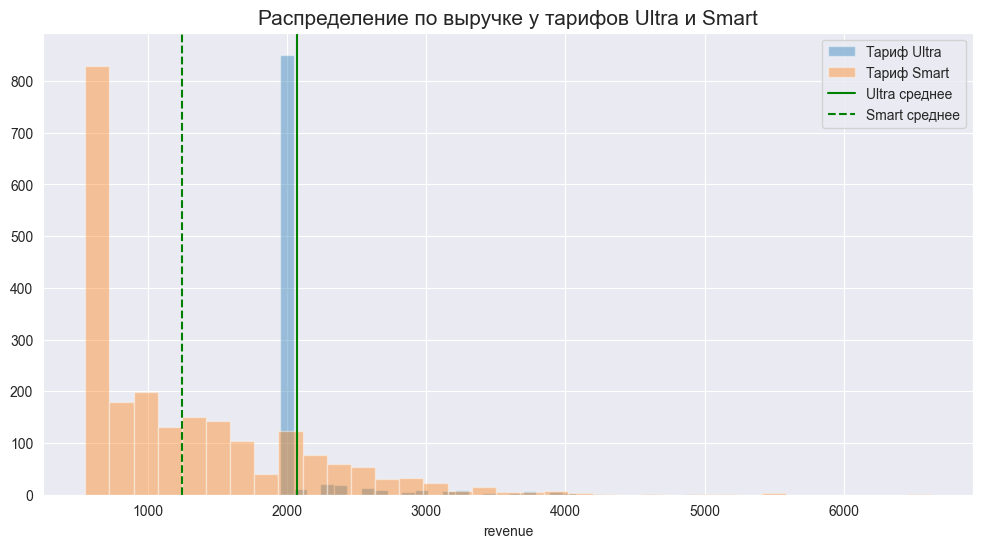

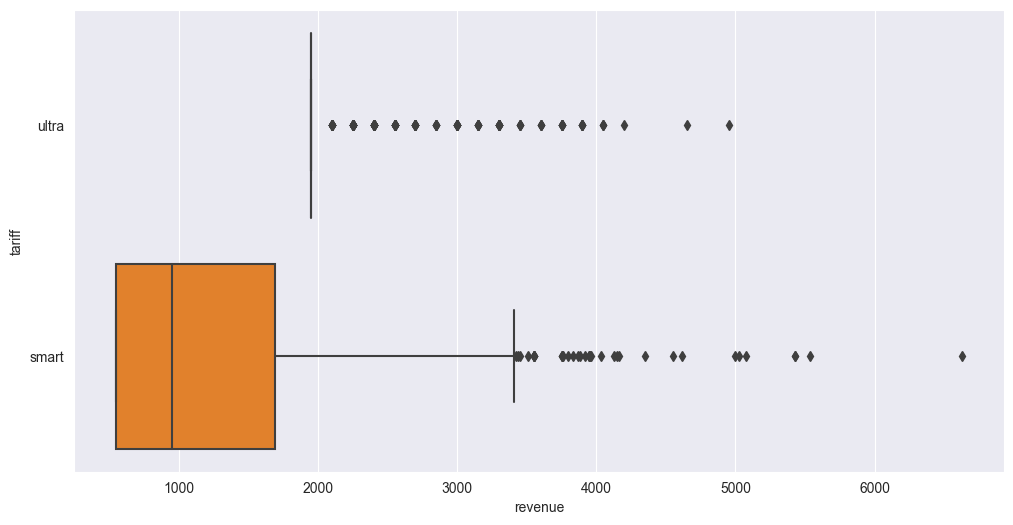

Тариф «Ультра»: 
 count     985.000000
mean     2072.436548
std       384.684107
min      1950.000000
25%      1950.000000
50%      1950.000000
75%      1950.000000
max      4950.000000
Name: revenue, dtype: float64

Тариф «Смарт»: 
 count    2229.000000
mean     1243.802153
std       800.877638
min       550.000000
25%       550.000000
50%       950.000000
75%      1694.000000
max      6625.000000
Name: revenue, dtype: float64


In [718]:
histogram_drawing('revenue', 'Распределение по выручке у тарифов Ultra и Smart') 

<div class="alert alert-block alert-info">
    <ul type='circle'>
        
## Вывод по анализу данных
        
   
       
**1. Распределение по минутам звонков у тарифов «Ультра» и «Смарт»:**
* 100% пользователей в тарифе «Ультра» (не считая выбросы) укладываются в 1300 минут.
* Более 75% пользователей в тарифе «Смарт» укладываются в 500 минут, хотя есть люди тратящие до 800+ минут.

**2. Распределение по колличеству сообщений у тарифов «Ультра» и «Смарт»:**
* 100% пользователей в тарифе «Ультра» (не считая выбросы) укладываются в 200 сообщений.
* Чуть меньше 75% пользователей в тарифе «Смарт» укладываются в 50 отведенных сообщений.

**3. Распределение по колличеству сообщений у тарифов «Ультра» и «Смарт»:**
* 75% пользователей в тарифе «Ультра» укладываются в 30 Гб. Чтобы покрыть все 100%, необходимо 50 Гб.
* Менее половины пользователей в тарифе «Смарт» укладываются в отведенные 15 Гб. Чтобы покрыть все 100%, необходимо 30+ Гб.
        
**4. Распределение по выручке у тарифов «Ультра» и «Смарт»:**
* 100% пользователей (не считая выбросы) в тарифе «Ультра» укладываются в месячный платеж 1950 рублей.
* Лишь четверть пользователей тарифа «Смарт» укладываются в стоимость пакета – 550 рублей. Почти 25% пользователей по итогу платят даже больше чем стоит тариф «Ультра».

## Шаг 4. Проверка гипотез

### 4.1 Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

* Нулевая гипотеза H₀: Средняя выручка пользователей тарифов Смарт и Ультра не различается 
* Альтернативная гипотеза H₁: Средняя выручка пользователей тарифов Смарт и Ультра различается

In [726]:
# Считаем среднюю выручку пользователей обоих тарифов

ultra_revenue = df.query('tariff == "ultra"')['revenue']
smart_revenue = df.query('tariff == "smart"')['revenue']

In [729]:
# Проверяем гипотезу

alpha = 0.05

results = scipy.stats.ttest_ind(ultra_revenue, smart_revenue, equal_var=False)

print('p-значение:', results.pvalue)


if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.8946643199410525e-279
Отвергаем нулевую гипотезу


### 4.2 Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

* Нулевая гипотеза H₀: Средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов
* Альтернативная гипотеза H₁: Средняя выручка пользователей ииз Москвы отличается от выручки пользователей из других регионов

In [733]:
# Считаем среднюю выручку пользователей из Москвы и других регионов

moscow_revenue = df.query('city == "Москва"')['revenue']
over_citys_revenue = df.query('city != "Москва"')['revenue']

In [734]:
# Проверяем гипотезу

alpha = 0.05

results = scipy.stats.ttest_ind(moscow_revenue, over_citys_revenue, equal_var=False)

print('p-значение:', results.pvalue)


if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.47670417276754606
Не получилось отвергнуть нулевую гипотезу


<div class="alert alert-block alert-info">
    <ul type='circle'>
        
## Вывод по анализу данных
        
   
       
**1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.**
Гипотеза оказалось верной. Вероятность того, что тарифы приносят одинаковую выручку менее 5%.
        
**2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.**
        Гипотеза оказалось не верной.

<div class="alert alert-block alert-info">
    <ul type='circle'>
        
## Шаг 5. Общий вывод
        
**Пользователям тарифа «Смарт» не хватает минут для звонков и сообщений. В тоже время для пользователей тарифа «Ультра» звонков и сообщений в пакете слишком много. Все пользователи используют менее половины объема предоставленного в тарифе.**
        
**А вот интернет – отдельная тема. Интернет-трафика не хватает пользователям обоих тарифов. Особенно пользователям тарифа «Смарт». Это объяснимо. Ведь люди все меньше звонят и шлют смс, и все больше коммуницируют через интернет. Плюс ежедневный контент для просмотра становится все более качественный, а значит и более тяжелый.**
       
**Гипотеза о различии средней выручки между тарифами оказалась правдивой. Даже несмотря на то, что пользователи тарифа «Смарт» платят за допы, цена этого тарифа все-равно ниже почти в 4 раза.**
        
**Гипотеза о различии средней выручки между Москвой и другими городами оказалась не правдой.**
        
**Исходя из анализов и тестов, стоит пересмотреть тарифы. В тарифе ультра можно сократить звонки и сообщения, но обязательно добавить интернет-трафика. В тарифе смарт не хватает всего, поэтому нужно либо добавить всего, либо сделать промежуточный тариф.** 